# SpaGFT Tutorial

## Outline
1. Installation
2. Import module
3. Loading Visium data
4. QC and preprocessing
5. Find Spatially variable genes
6. Detect tissue module
7. Imputation

## 1. Installation
SpaGFT is a python package to analysis spatial transcriptomics data. To install SpaGFT, the python version is requried to >= 3.7. You can check your python version by:

In [1]:
import platform
platform.python_version()

'3.7.9'

We recommend you create a virtual environment for running SpaGFT. You achieve this by conda easily:
```shell
conda create -n spagft python==3.8.0
conda activate spgft
```
If you want to exit this virtual envrionment, just run:
```shell
conda deactivate
```
Next, install SpaGFT by
```shell
git colne url
cd dir
conda install requiremnt.txt
python3 setup.py build
python3 setup.py install
```

## 2. Import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import SpaGFT as spg
import scanpy as sc
import seaborn as sns

sc.settings.verbosity = 3      
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 louvain==0.7.1 pynndescent==0.5.6


Define where save the results:

In [3]:
results_folder = './results/lymph_nodes_analysis/'

## 3. Loading Visium data

In this tutorial, we choosed lymph node Visium data generated by 10X, which could be download easily for analysis. For your personal datasets, just load data to _AnnData_ object. Note that, two parts are essential, count matrix and spatial information, which need to be found by _adata.X_ and _adata.obs_(or _adata.obsm_) respectively.

In [4]:
# Load data
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
# Pre-processing
adata.var_names_make_unique()
adata.raw = adata

reading D:\vir\SpaGFT\data\V1_Human_Lymph_Node\filtered_feature_bc_matrix.h5
 (0:00:00)


## 4. QC and preprocessing

We proceed to normalize Visium counts data with the built-in normalize_total method from Scanpy and filter genes which express less than 1o spots.

In [5]:
# QC
sc.pp.filter_genes(adata, min_cells=10)
# Normalization
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

filtered out 16788 genes that are detected in less than 10 cells
normalizing counts per cell
    finished (0:00:00)


## 5. Find Spatially variable genes

In [6]:
gene_df = spg.rank_gene_smooth(adata,
                                ratio_low_freq=0.5,
                                ratio_high_freq=3,
                                ratio_neighbors=1,
                                filter_peaks=True,
                                spatial_info=['array_row', 'array_col'],
                                normalize_lap=False)

Graph Fourier Transform finished!
SVG ranking could be found in adata.obs['Rank']
The spatially variable genes judged by gft_score could be found in adata.obs['cutoff_gft_score']
Gene signals in frequency domain could be found in adata.varm['freq_domain']


If you want to utilize other spatial information, such as pixel information, SpaGFT also provides other spatial information choise.

For example,

    gene_df = spg.rank_gene_smooth(adata, 
                          ratio_low_freq=0.5, 
                          ratio_high_freq=3, 
                          ratio_neighbors=1',
                          spatial_info=['array_row', 'array_col'],
                          cal_pval=True,
                          normalize_lap=False,
                          exp_scale=True,
                          filter_peaks=False,
                          S=10,
                          spec_norm=True,
                          n_low_freq=None,
                          a=2)

In [7]:
gene_df

,gene_ids,feature_types,genome,n_cells,gft_score,svg_rank,cutoff_gft_score,pvalue,qvalue
TMSB4X,ENSG00000205542,Gene Expression,GRCh38,4033,6.691849,1,True,7.552881e-20,2.311096e-16
EEF1A1,ENSG00000156508,Gene Expression,GRCh38,4031,6.436121,2,True,7.552881e-20,2.311096e-16
MT-CO2,ENSG00000198712,Gene Expression,GRCh38,4030,6.205767,3,True,7.552881e-20,2.311096e-16
MT-CO1,ENSG00000198804,Gene Expression,GRCh38,4024,6.039260,4,True,8.421331e-20,2.311096e-16
IFI44L,ENSG00000137959,Gene Expression,GRCh38,1882,5.831388,5,True,7.552881e-20,2.311096e-16
...,...,...,...,...,...,...,...,...,...
LINC00907,ENSG00000267586,Gene Expression,GRCh38,21,0.247214,19809,False,3.453487e-03,5.632783e-02
AC138150.2,ENSG00000267288,Gene Expression,GRCh38,55,0.229327,19810,False,4.115850e-02,5.711768e-01
LINC02513,ENSG00000248227,Gene Expression,GRCh38,13,0.225184,19811,False,9.346437e-01,1.000000e+00
LYRM1,ENSG00000102897,Gene Expression,GRCh38,1720,0.177426,19812,False,3.128106e-01,1.000000e+00


In [8]:
svg_list = gene_df[gene_df.cutoff_gft_score][gene_df.qvalue < 0.05].index.tolist()

In [9]:
svg_list[:30]

['TMSB4X',
 'EEF1A1',
 'MT-CO2',
 'MT-CO1',
 'IFI44L',
 'IGHG4',
 'ISG15',
 'MT-CO3',
 'IFIT1',
 'ACTG1',
 'RPL32',
 'MX1',
 'IGHM',
 'IGHG2',
 'CXCL12',
 'GAPDH',
 'IFI6',
 'ACTB',
 'RPL13',
 'NR4A1',
 'OASL',
 'IFI44',
 'IGHG1',
 'IGLON5',
 'IGLC2',
 'RPS18',
 'C7',
 'MT-ND1',
 'IGKC',
 'MT-ATP6']

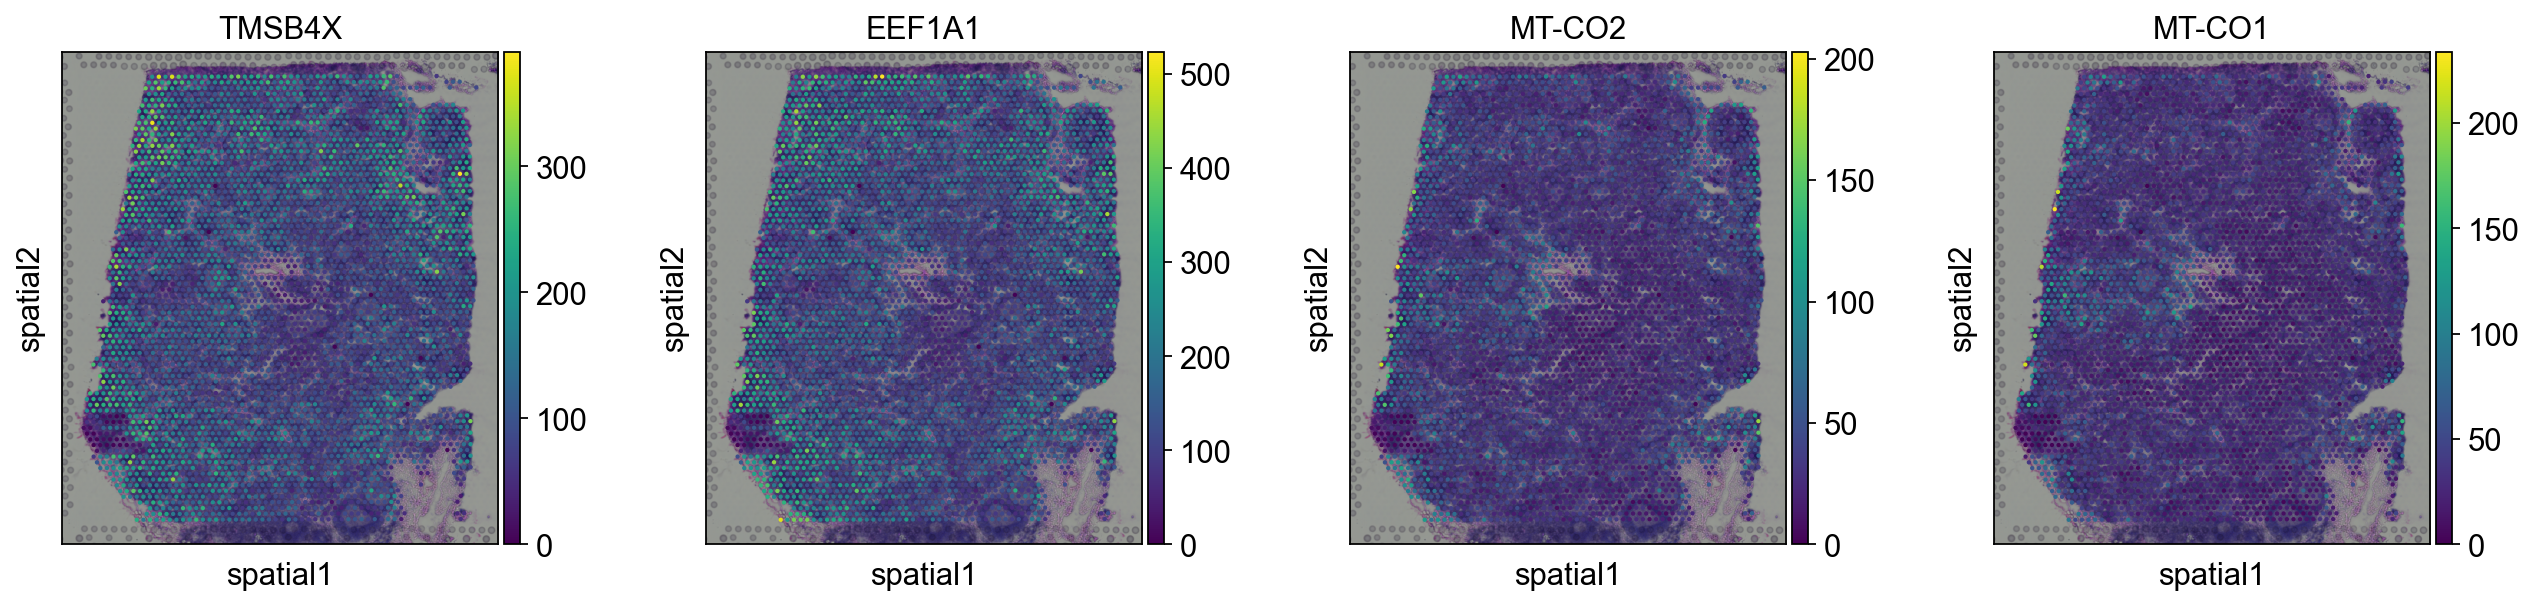

In [10]:
# visualizaiton
sc.pl.spatial(adata, color=svg_list[:4])

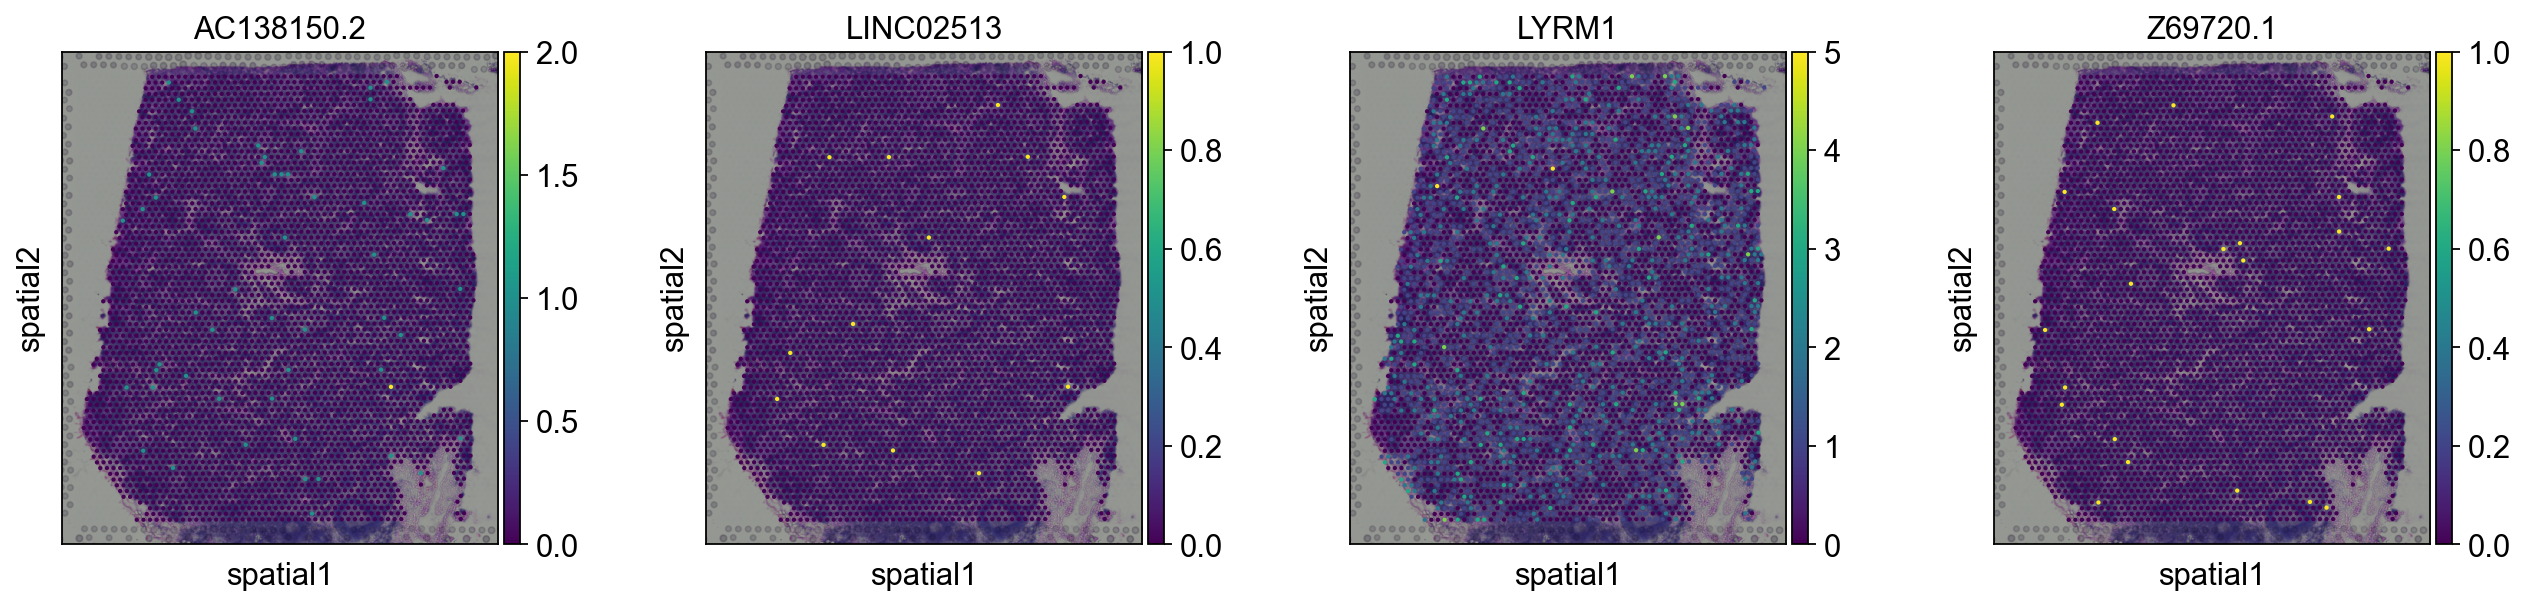

In [11]:
# Non-SVG
sc.pl.spatial(adata, color=gene_df.index[-4:])

## 6. Detect tissue module

In [12]:
# tissue_module
spg.gft.find_tissue_module(adata)

Gene signals in frequency domain could be found in  adata.varm['freq_domain']
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (

In [13]:
adata

AnnData object with n_obs × n_vars = 4035 × 19813
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'gft_score', 'svg_rank', 'cutoff_gft_score', 'pvalue', 'qvalue', 'tm_genes'
    uns: 'spatial', 'log1p', 'frequencies_svg', 'fms_low', 'fms_high'
    obsm: 'spatial', 'tm_expression', 'tm_region', 'subTm_expression', 'subTm_region'
    varm: 'freq_domain_svg', 'gft_umap'

In [14]:
tm_expression_df = adata.obsm['tm_expression']
tm_region_df = adata.obsm['tm_region']

In [15]:
tm_expression_df

,tm_0,tm_1,tm_2,tm_3,tm_4,tm_5,tm_6,tm_7,tm_8
AAACAAGTATCTCCCA-1,811.816284,21.251562,294.758545,327.317932,549.627380,136.096725,121.537712,79.748566,113.965004
AAACAATCTACTAGCA-1,845.484741,16.869364,206.962601,350.891907,606.646667,149.598633,211.799774,85.247086,84.046761
AAACACCAATAACTGC-1,1093.593018,31.936054,401.151550,397.577209,663.530151,201.130707,165.263626,119.332642,152.213745
AAACAGAGCGACTCCT-1,998.459351,38.056004,217.522034,344.772827,627.894836,188.153290,147.560684,201.873474,141.699539
AAACAGCTTTCAGAAG-1,864.739258,20.419729,201.246414,351.680603,635.475342,129.378296,107.839912,94.596077,157.801315
...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,691.250183,17.143034,257.553772,277.220703,510.685974,101.597679,100.518806,71.507774,111.129677
TTGTTTCATTAGTCTA-1,757.110779,16.928452,288.489380,291.452545,525.052673,122.959846,106.197037,75.882172,116.051086
TTGTTTCCATACAACT-1,749.673279,25.152254,279.799835,305.207855,543.656555,119.650681,123.183624,78.225006,125.823975
TTGTTTGTATTACACG-1,522.436951,17.507088,160.574860,212.388687,465.995361,70.464371,131.136246,51.271427,59.836788


In [16]:
tm_region_df

,tm_0,tm_1,tm_2,tm_3,tm_4,tm_5,tm_6,tm_7,tm_8
AAACAAGTATCTCCCA-1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
AAACAATCTACTAGCA-1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
AAACACCAATAACTGC-1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AAACAGAGCGACTCCT-1,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCATTAGTCTA-1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCCATACAACT-1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTGTATTACACG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 7. Imputation

In [17]:
new_count = spg.low_pass_imputation(adata)

In [18]:
new_count.iloc[:30, :10]

,AL627309.1,AL627309.5,LINC01409,LINC01128,LINC00115,FAM41C,AL645608.2,LINC02593,SAMD11,NOC2L
AAACAAGTATCTCCCA-1,0.057922,0.000000,0.123732,0.120787,0.169688,0.010857,0.000000,0.000000,0.000000,0.824052
AAACAATCTACTAGCA-1,0.009773,0.000000,0.082858,0.350739,0.110981,0.000242,0.000000,0.000000,0.022734,0.494006
AAACACCAATAACTGC-1,0.043066,0.000000,0.169158,0.380484,0.121529,0.051399,0.005639,0.033953,0.257416,0.723133
AAACAGAGCGACTCCT-1,0.022578,0.000000,0.003927,0.294820,0.124342,0.000000,0.022582,0.118576,0.053893,0.659887
AAACAGCTTTCAGAAG-1,0.000000,0.000000,0.094576,0.264345,0.000000,0.000000,0.000000,0.000000,0.083053,0.322552
AAACAGGGTCTATATT-1,0.000000,0.045970,0.070494,0.313387,0.095416,0.000000,0.001132,0.024493,0.134982,0.780335
AAACAGTGTTCCTGGG-1,0.000000,0.000088,0.122546,0.342871,0.020183,0.059540,0.000000,0.020432,0.075349,0.590394
AAACATTTCCCGGATT-1,0.000000,0.002259,0.012725,0.192993,0.033536,0.013908,0.010115,0.041186,0.169929,0.680637
AAACCCGAACGAAATC-1,0.035797,0.074092,0.009696,0.130326,0.009024,0.000000,0.000000,0.000000,0.000000,0.770570
AAACCGGGTAGGTACC-1,0.090989,0.027321,0.034444,0.569224,0.073350,0.068970,0.033405,0.000000,0.041777,0.598718
